In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from typing import Text, List, Tuple

from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

from xgboost import XGBRegressor
import xgboost as xgb

import pickle

In [2]:
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

pd.set_option("display.float_format", lambda x: "%.5f" % x)
pd.set_option("display.max_rows", 300)
pd.set_option("display.max_colwidth", 300)

In [3]:
DIRECTORY = "test_set_feature_prediction_2.csv"

In [4]:
def read_file(directory):
    df = pd.read_csv(directory)
    df['timestamp'] = pd.to_datetime(df['timestamp'], infer_datetime_format=True)
    return df

In [5]:
def date_features(df: pd.DataFrame) -> None:
    df['year'] = df.timestamp.dt.year
    df["month"] = df.timestamp.dt.month
    df["week"] = df.timestamp.dt.isocalendar().week
    df['daily'] = df.timestamp.dt.day
    df['hour'] = df.timestamp.dt.hour
    df['dayofweek'] = df.timestamp.dt.dayofweek

In [6]:
def lag_cyclical(df: pd.DataFrame) -> pd.DataFrame:
    dataframe_list = []

    unique_cell_id = set(df['cell_id'].values.tolist())

    for ids in unique_cell_id:
        tmp_df = df[df['cell_id'] == ids].copy()
        tmp_df['lag_1'] = tmp_df['traffic_mbps'].shift(1)
        tmp_df['lag_3'] = tmp_df['traffic_mbps'].shift(3)

        tmp_df['sin_day_of_week'] = np.sin(2*np.pi*tmp_df['dayofweek']/7)
        tmp_df['cos_day_of_week'] = np.cos(2*np.pi*tmp_df['dayofweek']/7)
        # tmp_df.dropna(inplace=True)

        dataframe_list.append(tmp_df)

    final_df = pd.concat(dataframe_list, ignore_index=True)
    return final_df

In [7]:
def categorical_encoding(df: pd.DataFrame) -> pd.DataFrame:
    datatypes = dict(zip(df.dtypes.index, df.dtypes))

    categorical_feats = []
    for names, col_type in datatypes.items():
        if (col_type == 'object') & (names not in ['cell_id', 'source_cell_id', 'target_cell_id']):
            categorical_feats.append(names)
    df_encoded = pd.get_dummies(df, columns=categorical_feats)
    df_encoded.dropna(inplace=True)
    return df_encoded

In [8]:
def plot_feature_importance(model: xgb.XGBRegressor):
    xgb.plot_importance(model, importance_type='weight', max_num_features=10, title='Feature Importance')

    plt.show()

In [9]:
df = read_file(directory=DIRECTORY)

df_demand = df[['cell_id','timestamp', 'traffic_mbps']].copy()
df_demand.set_index('timestamp', inplace=True)

/var/folders/f4/rlx43gn923q7mqwy45zvc1vm0000gn/T/ipykernel_1799/868000236.py:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['timestamp'] = pd.to_datetime(df['timestamp'], infer_datetime_format=True)


In [10]:
df_demand_new = df_demand.reset_index()
date_features(df_demand_new)

In [11]:
final_df = lag_cyclical(df_demand_new)

item_to_remove = ['alarm_code', 'traffic_mbps']
data_cols = df.columns.to_list()

for features in data_cols:
    if features in item_to_remove:
        data_cols.remove(features)

df_first_selection = df[data_cols].copy()

In [14]:
merged_df = pd.merge(df_first_selection, final_df, how='left', on=['timestamp', 'cell_id'])

df_encoded = categorical_encoding(df=merged_df)

In [29]:
test_data = df_encoded[df_encoded['timestamp'].dt.year == 2024]
train_data = df_encoded[df_encoded['timestamp'].dt.year < 2024]

drop_features = ['traffic_mbps', 'model_prediction']

final_train = train_data.drop(columns=drop_features)
final_test = test_data.drop(columns=drop_features)
label_train = train_data['traffic_mbps'].copy()
label_test = test_data['traffic_mbps'].copy()

drop_features_2 = ['cell_id', 'timestamp', 'source_cell_id', 'target_cell_id','Unnamed: 0']
x_train = final_train.drop(columns=drop_features_2)
x_train = x_train.astype('float64')
x_test = final_test.drop(columns=drop_features_2)
x_test = x_test.astype('float64')

In [30]:
xgb_model = XGBRegressor(objective='reg:squarederror')
xgb_model.fit(x_train, label_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [31]:
train_predictions = xgb_model.predict(x_train)

# test_prediction = xgb_model.predict(x_test)

In [19]:
xgb_model.save_model("./xgb_model.bin")

/usr/local/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [17:53:23] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


In [20]:
xgb_model_loaded = XGBRegressor()
xgb_model_loaded.load_model("./xgb_model.bin")

y_pred = xgb_model_loaded.predict(x_test)

In [27]:
x_train.columns

Index(['Unnamed: 0', 'latency_ms', 'packet_loss_rate_percent', 'load_percent', 'active_users', 'spectrum_mhz', 'handover_attempts', 'handover_failures', 'rsrp_dBm', 'rsrq_dB', 'sinr_dB', 'spectrum_utilization_percent', 'congestion_level_percent', 'year_x', 'month_x', 'week_x', 'daily_x', 'hour_x', 'dayofweek_x', 'lag_1_x', 'lag_3_x', 'sin_day_of_week_x', 'cos_day_of_week_x', 'band_Band1', 'band_Band2', 'band_Band3', 'issue_description_Equipment failure', 'issue_description_Network instability', 'issue_description_Overload', 'issue_description_Signal loss', 'year_y', 'month_y', 'week_y', 'daily_y', 'hour_y', 'dayofweek_y', 'lag_1_y', 'lag_3_y', 'sin_day_of_week_y', 'cos_day_of_week_y'], dtype='object')

### Optional: But you can use Pickle if it works best for the gcp or the agentic AI you are setting up

In [32]:
with open("./xgb_model.pkl", "wb") as f:
    pickle.dump(xgb_model, f)


# with open("./xgb_model.pkl", "rb") as f:
#     xgb_model_loaded = pickle.load(f)

# y_pred_pickle = xgb_model_loaded.predict(x_test)

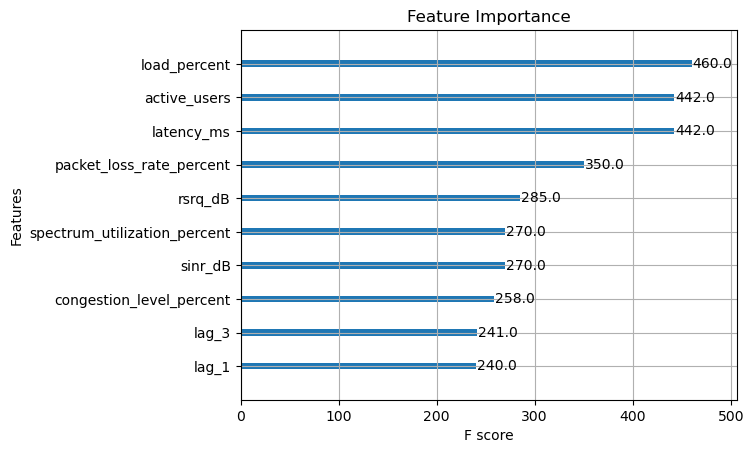

In [27]:
plot_feature_importance(xgb_model)